# Notebook for making the animations by interpolation

Use this after you train a model. Add the path to your model state dict below:

In [1]:
model_path = '' # put your model state dict path here

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from torch import nn
from torch import optim
import torch.functional as F

In [4]:
DEVICE = torch.device('cuda')
torch.backends.cudnn.benchmark = True

In [5]:
from pylab import *

In [6]:
import imageio
import os
from IPython.display import *

In [7]:
rcParams['figure.figsize']=18,7
rcParams['font.size']=15
rcParams['axes.grid']=True

style.use('dark_background')

In [8]:
from lines_curves_dataset import *
from modules import *
from autoenc_models import *

## Get a dataset to test modules

In [9]:
from torchvision.transforms import *

In [10]:
batch_size = 16
batches_per_epoch = 1000
validation_batches = 100

In [11]:
dataset_config = {
    'nlines_range':(0, 3), 
    'ncurves_range':(1, 4), 
    'nellipses_range':(0, 3), 
    'x_range':(0, 64), 
    'y_range':(0, 64), 
    'dilation_size_range':(3, 6), 
    'img_size':(64, 64), 
    'blur_sigma':0.7,
}

In [12]:
transform = Normalize([0.5],[0.5])

In [13]:
transform = None

In [14]:
dset = LinesCurvesDataset(imgs_per_epoch=batch_size*batches_per_epoch, 
                          **dataset_config, 
                          device=DEVICE,
                          transform=transform,)

In [15]:
val_dset = LinesCurvesDataset(imgs_per_epoch=batch_size*validation_batches, 
                          **dataset_config, 
                          device=DEVICE,
                          transform=transform,)

In [16]:
train_loader = DataLoader(dset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dset, batch_size = batch_size, shuffle=True)
loader = iter(train_loader)

torch.Size([8, 1, 64, 64]) 1.0 0.0 0.17750823497772217


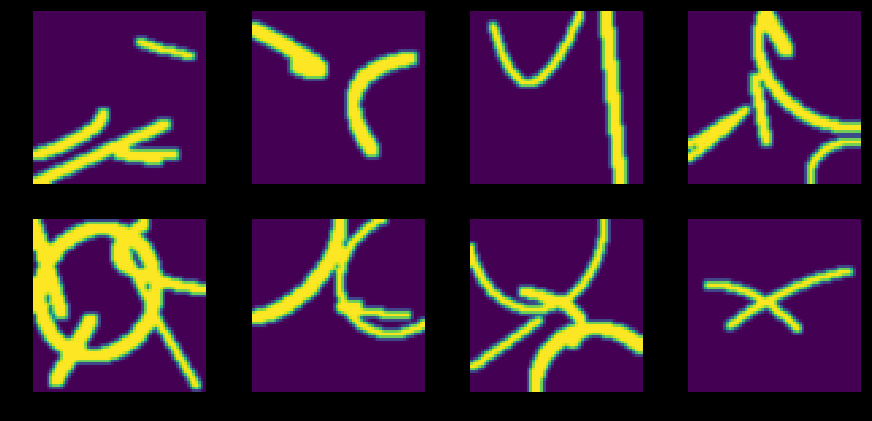

In [17]:
num=8
sample_inp = next(loader)[:num]
print(sample_inp.shape, sample_inp.max().item(), sample_inp.min().item(), sample_inp.mean().item())

subplots(num//4,4,figsize=(15,7))
for i, im in enumerate(sample_inp):
    subplot(num//4,4,i+1)
    axis('off')
    imshow(im.cpu().numpy().transpose([1,2,0]).squeeze())

# Instantiate the models

## coord conv with 64 hidden size

In [ ]:
encoder, decoder, autoencoder = coordconv_conv64(DEVICE)

autoencoder.load_state_dict(torch.load(model_path))

## Testing

In [19]:
autoencoder = autoencoder.eval()
enc = encoder.eval()
dec = nn.Sequential(decoder, nn.Hardtanh()).eval()

In [ ]:
with torch.no_grad():
    num = 4
    inp = next(loader)[:num]
    print(inp.shape)
    out = autoencoder(inp)
    
    subplots(num//4,4,figsize=(15,3))
    for i, im in enumerate(inp):
        subplot(num//4,4,i+1)
        axis('off')
        imshow(im.cpu().numpy().transpose([1,2,0]).squeeze())
        
    subplots(num//4,4,figsize=(15,3))
    for i, im in enumerate(out):
        subplot(num//4,4,i+1)
        axis('off')
        imshow(im.cpu().numpy().transpose([1,2,0]).squeeze())
    

## Helper functions for interpolating

In [21]:
def linearInterpolate(vec1,vec2,num=50):
    """Linearly interpolate between the two given numpy arrays, 
    and returns a numpy array with stacked frames"""
    differ = (vec2-vec1)/(num-1)
    differs = array([differ]*num)
#     print(f"differs shape {differs.shape}")
    mults = arange(num).reshape([-1]+[1]*len(vec1.shape))
    interp = vec1 + differ*mults
#     print(f"interp shape {interp.shape}")
    return interp

In [22]:
def circularInterpolate(vec1, vec2, num=50):
    """Circularly interpolate between the two given numpy arrays, 
    and returns a numpy array with stacked frames"""
    interp = linearInterpolate(vec1,vec2,num)
    n1 = norm(vec1.reshape(-1))
    n2 = norm(vec2.reshape(-1))
    # print(interp.shape)
    norms = norm(interp.reshape(interp.shape[0],-1),axis=1)
    # print(norms.shape)
    interp = interp/norms.reshape([-1]+[1]*len(vec1.shape))

    interp_norms = linearInterpolate(n1,n2,num)
    interp = interp*interp_norms.reshape([-1]+[1]*len(vec1.shape))
    return interp

In [23]:
def brownian_bridge(*shape, std=1, num=100):
    """Make a brownian bridge starting and ending at 0, with the given std and shape.
    num points are sampled."""
    diffs = randn(num-1, *shape)*std
    walk = concatenate((zeros((1,)+shape),cumsum(diffs, axis=0)), axis=0)
    t = linspace(0,1,num).reshape([-1]+[1]*len(shape))
    bridge = walk - t*walk[-1]
    
    return bridge

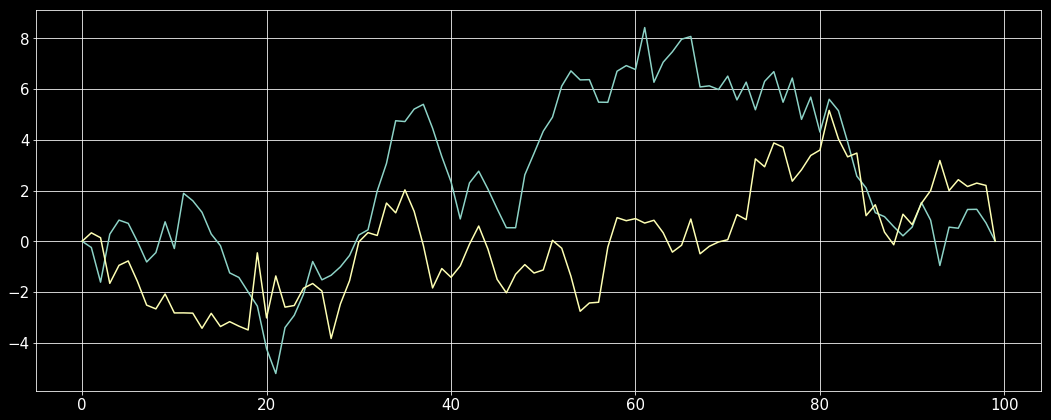

In [24]:
test_bridge = brownian_bridge(2)

plot(test_bridge[:,0])
plot(test_bridge[:,1])

## Helper functions to get a generator of images

### From a directory

In [25]:
def bmps_from_dir(dirname):
    """Yields bmps from the given folder. Converts to grayscale torch cpu tensors
    with shape (H,W)."""
    with torch.no_grad():
        for filename in os.listdir(dirname):
            if os.path.splitext(filename)[1].lower() != '.bmp':continue

            img_file = os.path.join(dirname,filename)

            # read as rgb image:
            read_im = torch.FloatTensor(imageio.imread(img_file).astype('float32')/255.0).squeeze().mean(dim=-1)
            
            yield read_im

### From one image with a grid of images

In [26]:
def bmps_from_grid_image(img_path, h=64, w=64, img_num=None):
    """Yields images of size (h,w) row major left to right from an input image grid.
    The input is assumed to be one single image, with a grid of smaller images of the given
    size.
    img_num: number of images to yield. If None, yields all images.
    """
    with torch.no_grad():
        count = 0
        read_im = torch.FloatTensor(imageio.imread(img_path).astype('float32')/255.0).squeeze().mean(dim=-1)
        H,W = read_im.shape
        for i in range(0,H,h):
            for j in range(0,W,w):
                yield read_im[i:i+h,j:j+w]
                count += 1
                if img_num != None and count >= img_num:
                    return read_im
                
    return read_im

## Make a gif from an iterator yielding images using an encoder and decoder

In [27]:
def iterator_to_gif_brownian(img_iterator, encoder, decoder, outname=None, mode='circular', std=1, num=100, duration=0.03):
    """Interpolates between images yielded from an iterator in latent space using linear or circular
    interpolation with the given encoder and decoder. Adds a brownian bridge of given std to the 
    interpolating path. Writes the gif to the given output file name.
    
    The iterator should yield images which are torch float tensors of shape (H,W). (Grayscale images)
    """
    modes = {
        'linear':linearInterpolate,
        'circular':circularInterpolate,
    }
    interpolate = modes[mode]
    with torch.no_grad():
        
        decoder = decoder.eval()
        encoder = encoder.eval()
            

        embed_old = None
        embed = None
        
        final = None
        
        for read_im in img_iterator:
            read_im = read_im.to(DEVICE)
            
            # encode
            embed = encoder(read_im.to(DEVICE).unsqueeze(0).unsqueeze(0)).cpu().numpy().squeeze(0)
            if type(embed_old) == type(None):
                embed_old = embed.copy()
                continue
                
            # interpolate
            interp = interpolate(embed_old, embed, num)
            interp += brownian_bridge(*embed.shape, std=std, num=num)
            interp = torch.Tensor(interp).to(DEVICE)

#             print(f"what will be decoded shape {interp.shape}")
            # decode
            outs = decoder(interp).squeeze().cpu().numpy()
            
            # concat frames
            if type(final) == type(None):
                final = outs.copy()
            else:
                final = concatenate((final,outs))
                
            embed_old = embed.copy()
            
        # write gif
        outname = outname if outname != None else 'interpolated.gif'
        imageio.mimwrite(outname,(final*255).astype('uint8'),duration=duration)

# Make a gif using different interpolation methods

In [28]:
from scipy.interpolate import interp1d

In [29]:
def images_to_gif_brownian(images, enc, dec, outname=None, std=0, num_frames=100, kind='linear', batch_size=16,
                          duration=0.03):
    """Interpolates between the given tensor of images using the encoder and decoder.
    num_frames frames are created in the gif between each image. 
    Batch size is for evaluation.
    
    `kind` is passed into scipy.interpolate.interp1d `kind`. It's doc is:
    kind : str or int, optional
        Specifies the kind of interpolation as a string
        ('linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic'
        where 'zero', 'slinear', 'quadratic' and 'cubic' refer to a spline
        interpolation of zeroth, first, second or third order) or as an
        integer specifying the order of the spline interpolator to use.
        Default is 'linear'.
    """
    
    with torch.no_grad():
        
        images = images.to(DEVICE)
        num_images = images.shape[0]
        batches = int(ceil((num_images-1)*num_frames/batch_size))
        x = linspace(0,1,num_images)
        
        embeds = enc(images)
        
        # function which interpolates
        interpolater = interp1d(x, embeds.cpu().numpy(), axis=0, assume_sorted=True, kind=kind)
        
        new_x = linspace(0,1,(num_images-1)*num_frames)
        interp_embeds = interpolater(new_x)
        
        bridges = concatenate([brownian_bridge(*interp_embeds[0].shape, std=std, num=num_frames)
                               for _ in range(num_images-1)])
        interp_embeds += bridges
        
        interp_embeds = torch.FloatTensor(interp_embeds).to(DEVICE)
        
        final = None
        for i in range(batches):
            outs = dec(interp_embeds[i*batch_size:(i+1)*batch_size]).squeeze().cpu().numpy()
            
            
            if type(final) == type(None):
                final = outs.copy()
            else:
                final = concatenate((final,outs))
                
        # write gif
        outname = outname if outname != None else 'interpolated.gif'
        imageio.mimwrite(outname,(final*255).astype('uint8'),duration=duration)

## Make a gif from an image grid

Add these params and run the cells to create a gif. 

In [30]:
input_grid_image_path = 'tree.bmp' # path for the input image grid
output_gif_path = 'tree.gif' # output gif path
std=0.8 # standard deviation for the brownian bridge

In [31]:
img_gen = bmps_from_grid_image(input_grid_image_path, img_num=6)
iterator_to_gif_brownian(img_gen,
                         enc,
                         dec, 
                         outname=output_gif_path,
                         std=std,
                         num=100,
                         mode='linear')

In [32]:
kind = 'cubic' # which kind of interpolation to use

In [33]:
img_gen = bmps_from_grid_image(input_grid_image_path, img_num=6)
ims = list(img_gen)
ims = array([im.cpu().numpy() for im in ims])
images = torch.FloatTensor(ims).to(DEVICE).unsqueeze(1)

images_to_gif_brownian(images,
                         enc,
                         dec, 
                         outname=output_gif_path,
                         std=std,
                         num_frames=20,
                         kind=kind,
                         batch_size=10)